#### 분류평가
- 정확도만으로 불균형한 레이블 데이터 세트에서 평가지표로 사용하기에는 부적합
- 정확도가 가지는 분류 평가의 지표로의 한계점을 극복하기 위해 여러가지 분류지표와 함께 적용해야 함

#### Confusion matrix(혼동행렬, 오차행렬)
- 이진분류에서 성능지표로 잘 활용되는 오차행렬은 학습된 분류 모델이 예측을 수행하면 얼마나 혼동될수 있는지도 함께 보여주는 지표
- 이진 분류의 예측 오류가 얼마인지와 더붙어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 보여줌

#### 평가지표
- TP,FP,TN,FN은 예측 클래스와 실제 클래스의 Positive 결정값과 Negative 결정 값의 결합에 따라 결정
- 아문자 True/False는 예측값과 실제값이 같은가/틀린가를 의미하고 뒤 문자 N/P는 예측 결과값이 부정/긍정을 의미
- 정확도 = (TP + TN) / (TP+TN+FP+FN)
- 정밀도 = TP / (TP + FP) : P로 예측한것 중에서 실제도 P
- 재현율 = TP / (TP + FN) : 실제 P인 것중에서 예측도 P
- F1 = 2 * (정밀도 * 재현율) / (정밀도 + 재현율) : 정밀도와 재현률이 어느 한쪽으로 치우치지 않는 수치를 나타낼때 높아짐
- 정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
- 재현율이 중요 지표인 경우 : 양성 데이터를 음성으로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(암진단, 보험사기)
- 정밀도가 더 중료한 지표인 사례 : 스팸 메일 여부를 판단하는 경우로 스팸 메일이 아닌데 스팸 메일로 분류해서 업무 차질 발생. 
누락이 발생하면 안되는 것?

#### 정밀도 및 재현율 활용 시 유의사항
- 정밀도와 재현율 성능 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능
- 정밀도 100%가 되는 방법 : 확실한 기준이 되는 경우만 P로 예측하고 나머지는 모두 N로 예측 TP/(TP+FP) = 1 / (1+0) = 1
- 재현율이 100%가 되는 방법 : 실제 양성 1000명중 30명 TP/(TP+FN) 30/(30+0) = 1
- 분류가 정밀도, 재현율 중 하나에 상대적인 중요도를 부여할 수 있지만 하나만 강조해서는 안됨
- 암 예측 모델에서 재현울을 높인다고 주로 양성만 판정한다면 환자의 불만과 불평이 커지게 됨

In [108]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

def fillnas(df):
    def callname(x):
        m = re.compile('[A-Za-z]+[.]')
        p = re.findall(m,x)
        return p[0]
    
    df['Callname']=df.Name.apply(lambda x:callname(x))
    
    df1 = df.loc[df.Age.isnull()]
    age_nulllist = list(set(df1.Callname.values.tolist()))
    
    df2 = df.loc[df.Age.notnull()]
    pivot = pd.pivot_table(df2, index = 'Callname', values = 'Age',aggfunc = 'mean')
    
    for age in age_nulllist:
        df.loc[(df.Age.isnull())&(df.Callname == age),['Age']]=(pivot.loc[age][0])
        
    df['Embarked'].fillna(method = 'ffill',inplace=True)
    
    df3 = df.loc[df.Cabin.notnull()]

    df3['Cabins'] = df3['Cabin'].str[:1]
    df4 = df.loc[df.Cabin.isnull()]
    
    for i in range(1,4):
        df33 = df3.loc[df3.Pclass == i]
        cabin_fill_list=list(set(df33.Cabins.values.tolist()))
        df44 = df4.loc[df4.Pclass == i]
        fill_index = list(df44.index)
        for index in fill_index:
            df.loc[index,'Cabin'] = np.random.choice(cabin_fill_list)
            
    return df

# 불필요 항목 제거
def drop_feat(df):
    df.drop(['PassengerId','Name','Ticket','Callname'],axis=1,inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    scaler = MinMaxScaler()
    scaler.fit(df[['Fare']])
    fare_scaled = scaler.transform(df[['Fare']])
    df['Fare'] = fare_scaled
    
    return df

def transform_features(df):
    df = fillnas(df)
    df = drop_feat(df)
    df = format_features(df)
    return df

In [109]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)

    print('오차행렬')
    print(confusion)
    print(f'정확도 : {round(accuracy,4)}, 정밀도 : {round(precision,4)}, 재현율 : {round(recall,4)}')    

In [110]:
import warnings
warnings.filterwarnings('ignore')
t_df = pd.read_csv('./dataset/train.csv')
y_t_df = t_df['Survived']
X_t_df = t_df.drop('Survived',axis=1)
X_t_df = transform_features(X_t_df)
X_t_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,0.014151,5,2
1,1,0,38.0,1,0,0.139136,2,0
2,3,0,26.0,0,0,0.015469,4,2
3,1,0,35.0,1,0,0.103644,2,2
4,3,1,35.0,0,0,0.015713,5,2


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X_t_df,y_t_df,test_size=0.2,random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차행렬
[[106  12]
 [ 15  46]]
정확도 : 0.8492, 정밀도 : 0.7931, 재현율 : 0.7541


In [112]:
TN = 109  
FN = 9 
FP = 15 
TP = 46

accuracy = (TP + TN) / (TP+TN+FP+FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2*(precision*recall)/(precision+recall)

print('accuracy : ', round(accuracy,4))
print('precision : ', round(precision,4))
print('recall : ', round(recall,4))
print('f1 score : ', round(f1,4))

accuracy :  0.8659
precision :  0.7541
recall :  0.8364
f1 score :  0.7931


In [113]:
# Precision/Recall Trade-off
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
pred_proba_result[:3]

array([[0.50473076, 0.49526924, 0.        ],
       [0.87199555, 0.12800445, 0.        ],
       [0.87415994, 0.12584006, 0.        ]])

In [114]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [115]:
custom_threshold = 0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
get_clf_eval(y_test,custom_predict)


오차행렬
[[106  12]
 [ 15  46]]
정확도 : 0.8492, 정밀도 : 0.7931, 재현율 : 0.7541


In [116]:
# 분류 결정 임계값을 0.5 -> 0.4
custom_threshold = 0.4
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
get_clf_eval(y_test,custom_predict)

오차행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197


In [117]:
for i in [0.40,0.45,0.50,0.55,0.60]:
    custom_threshold = i
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    print('임계값 : ',i)
    get_clf_eval(y_test,custom_predict)
    print('\n')

임계값 :  0.4
오차행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197


임계값 :  0.45
오차행렬
[[99 19]
 [13 48]]
정확도 : 0.8212, 정밀도 : 0.7164, 재현율 : 0.7869


임계값 :  0.5
오차행렬
[[106  12]
 [ 15  46]]
정확도 : 0.8492, 정밀도 : 0.7931, 재현율 : 0.7541


임계값 :  0.55
오차행렬
[[111   7]
 [ 15  46]]
정확도 : 0.8771, 정밀도 : 0.8679, 재현율 : 0.7541


임계값 :  0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.898, 재현율 : 0.7213




In [118]:
from sklearn.metrics import f1_score
def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    print('오차행렬')
    print(confusion)
    print(f'정확도 : {round(accuracy,4)}, 정밀도 : {round(precision,4)}, 재현율 : {round(recall,4)},f1 score : {round(f1,4)}')
get_clf_eval(y_test,pred)


오차행렬
[[106  12]
 [ 15  46]]
정확도 : 0.8492, 정밀도 : 0.7931, 재현율 : 0.7541,f1 score : 0.7731


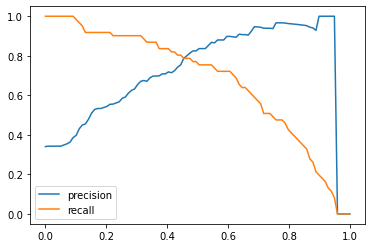

In [119]:
# [과제] 임곗값을 0 ~ 1사이로 변경시킬때 precison,recall의 변화 추세를 시각화하여 출력하세요.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.metrics import precision_score,recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

t_df = pd.read_csv('./dataset/train.csv')
y_t_df = t_df['Survived']
X_t_df = t_df.drop('Survived',axis=1)
X_t_df = transform_features(X_t_df)

X_train, X_test, y_train, y_test = train_test_split(X_t_df,y_t_df,test_size=0.2,random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

xs = np.linspace(0,1,100)
precision = []
recall = []
for i in xs:
    custom_threshold = i
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba)
    custom_predict = binarizer.transform(pred_proba)
    precision.append(precision_score(y_test,custom_predict))
    recall.append(recall_score(y_test,custom_predict))

plt.plot(xs,precision,label='precision')
plt.plot(xs,recall,label = 'recall')
plt.legend()


[0.09091557825728792, 0.09332198465546408, 0.09370958711469968, 0.097381530994585, 0.0977709489841712, 0.09860116049682499, 0.09923558246242985, 0.10250567011764032, 0.103424671145402, 0.1038007682141812, 0.10554785548196113, 0.10558505145908752, 0.10559393458657171, 0.10668913373345099, 0.10674098488499566, 0.10688482672525226, 0.10749618345216373, 0.11097845455893005, 0.11219345598235493, 0.11259799280542586, 0.11559062990990551, 0.11559661028278233, 0.11798378167337001, 0.11901232955621416, 0.12078327813944027, 0.12086567746335738, 0.12132095763791594, 0.12316822864606199, 0.1255713033562694, 0.12583321239504458, 0.12779998351946179, 0.13037087161759722, 0.13225734181569834, 0.13414511377575927, 0.13601873642850287, 0.13661761547530374, 0.13688086903941246, 0.144872530571553, 0.14684655901943325, 0.1475367513583469, 0.14938315969069957, 0.1498416350136996, 0.15099473437845534, 0.1513044770484356, 0.1515704649836958, 0.15202129532695832, 0.15409914092672786, 0.16105207034591426, 0.16

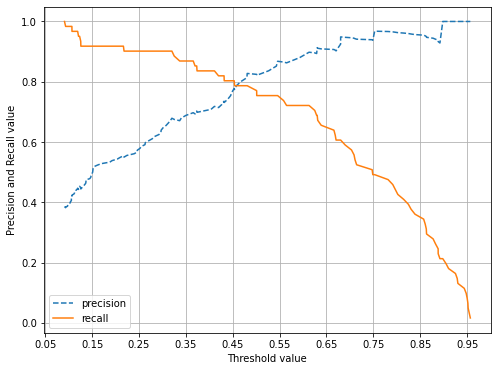

In [120]:
# precision_recall_curve() API는 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프로 
# 시각화하는데 이용
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    print(list(thresholds))
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    print(threshold_boundary)
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

#### ROC Curve와 AUC
- 수신자 판단 곡선이라고 하며 ML의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표
- FPR이 편할 때 TPR이 어떻게 변하는지를 나타내는 곡선으로 FPR = 1 - TNR(특이성), TPR은 재현율(민감도)를 나타냄
- TNR = TN/(TN + FP)이며 FPR은 FP/(TN + FP)
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR의 변화 값을 구함
- FPR을 0에서 1까지 변경하는 것은 P 예측값을 결정하는 기준인 분류 결정 인곗값을 변경하면 됨.
- FPR을 0으로 만들려면 임곗값을 1로 지정하고 반대로 FPR을 1로 만들려면 임곗값을 0으로 지정

In [121]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
def roc_curve_plot(y_test, pred_proba):   
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba)

    plt.plot(fprs,tprs,label = 'ROC')
    plt.plot([0,1],[0,1],'k--',label = 'Random')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1- Specificity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

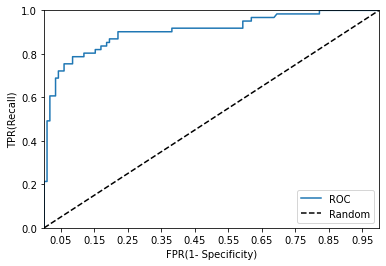

In [122]:
roc_curve_plot(y_test,pred_proba_c1)

In [123]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test,pred_proba)
round(roc_score,4)

0.9055

In [124]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print('오차행렬')
    print(confusion)
    print(f'정확도 : {round(accuracy,4)}, 정밀도 : {round(precision,4)}, 재현율 : {round(recall,4)},f1 score : {round(f1,4)}, auc : {round(roc_auc,4)}')

In [125]:
get_clf_eval(y_test,pred,pred_proba_c1)

오차행렬
[[106  12]
 [ 15  46]]
정확도 : 0.8492, 정밀도 : 0.7931, 재현율 : 0.7541,f1 score : 0.7731, auc : 0.9055


[과제] train.csv 파일을 불러와서 분류모델링 평가를 아래와 같이 수행하세요.
- dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
- accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가


In [126]:
df = pd.read_csv('./dataset/train.csv')
transform_features(df)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.000000,1,0,0.014151,5,2
1,1,1,0,38.000000,1,0,0.139136,2,0
2,1,3,0,26.000000,0,0,0.015469,5,2
3,1,1,0,35.000000,1,0,0.103644,2,2
4,0,3,1,35.000000,0,0,0.015713,5,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,0.025374,4,2
887,1,1,0,19.000000,0,0,0.058556,1,2
888,0,3,0,21.773973,1,2,0.045771,5,2
889,1,1,1,26.000000,0,0,0.058556,2,0


In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
import warnings
warnings.filterwarnings('ignore')

df_x = df.drop('Survived',axis=1)

X_train, X_test , y_train, y_test = train_test_split(df_x,df['Survived'],test_size=0.2,random_state=11)

dtree = DecisionTreeClassifier()
parameters = {'max_depth':[2,3,5,10],'min_samples_split':[2,3,5],'min_samples_leaf':[1,2,3]}
grid_dtree = GridSearchCV(dtree,param_grid=parameters,cv=3,refit=True)

grid_dtree.fit(X_train,y_train)
scores_df = pd.DataFrame(grid_dtree.cv_results_)
display(scores_df[['params','mean_test_score','rank_test_score']])
print('최적 파라미터 : ',grid_dtree.best_params_)
pred = grid_dtree.best_estimator_.predict(X_test)
pred_proba = grid_dtree.best_estimator_.predict_proba(X_test)[:,1]

confusion = confusion_matrix(y_test,pred)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
roc_auc = roc_auc_score(y_test,pred_proba)
print('오차행렬 : \n',confusion)
print(f'정확도 : {round(accuracy,4)}, 정밀도 : {round(precision,4)}, 재현율 : {round(recall,4)},f1 score : {round(f1,4)}, roc auc score : {round(roc_auc,4)}')


,params,mean_test_score,rank_test_score
0,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.778126,22
1,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.778126,22
2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.778126,22
3,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.778126,22
4,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.778126,22
5,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.778126,22
6,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",0.778126,22
7,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",0.778126,22
8,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",0.778126,22
9,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.801989,4


최적 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
오차행렬 : 
 [[110   8]
 [ 13  48]]
정확도 : 0.8827, 정밀도 : 0.8571, 재현율 : 0.7869,f1 score : 0.8205, roc auc score : 0.9111


[과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.

- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가<br>
※ 피처 정보<br>
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린), 'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'




- 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임.
- 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생

In [128]:
diabetes_data = pd.read_csv('./dataset/diabetes.csv')
diabetes_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [129]:
# SkinThickness 와 Insulin의 0값 평균값으로 대체
d_df = diabetes_data.copy()
d_df.SkinThickness.loc[d_df.SkinThickness==0] = d_df.SkinThickness.mean()
d_df.Insulin.loc[d_df.Insulin==0]=d_df.Insulin.mean()
d_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.000000,79.799479,33.6,0.627,50,1
1,1,85,66,29.000000,79.799479,26.6,0.351,31,0
2,8,183,64,20.536458,79.799479,23.3,0.672,32,1
3,1,89,66,23.000000,94.000000,28.1,0.167,21,0
4,0,137,40,35.000000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48.000000,180.000000,32.9,0.171,63,0
764,2,122,70,27.000000,79.799479,36.8,0.340,27,0
765,5,121,72,23.000000,112.000000,26.2,0.245,30,0
766,1,126,60,20.536458,79.799479,30.1,0.349,47,1


In [130]:
X_train,X_test,y_train,y_test = train_test_split(d_df.drop('Outcome',axis=1),d_df['Outcome'],test_size=0.2,random_state=11)
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[2,3,5,10],'min_samples_split':[2,3,5],'min_samples_leaf':[1,2,3]}
grid_dtree = GridSearchCV(dtree,param_grid=parameters,cv=3,refit=True)

grid_dtree.fit(X_train,y_train)
scores_df = pd.DataFrame(grid_dtree.cv_results_)
display(scores_df[['params','mean_test_score','rank_test_score']])
print('최적 파라미터 : ',grid_dtree.best_params_)
pred = grid_dtree.best_estimator_.predict(X_test)
pred_proba = grid_dtree.best_estimator_.predict_proba(X_test)[:,1]

,params,mean_test_score,rank_test_score
0,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.747521,1
1,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.747521,1
2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.747521,1
3,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.747521,1
4,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.747521,1
5,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.747521,1
6,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",0.747521,1
7,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",0.747521,1
8,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",0.747521,1
9,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.734497,16


최적 파라미터 :  {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [131]:
# 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
def scores(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(f'정확도 : {round(accuracy,4)}, 정밀도 : {round(precision,4)}, 재현율 : {round(recall,4)},f1 score : {round(f1,4)}, roc auc score : {round(roc_auc,4)}')

scores(y_test,pred,pred_proba)

정확도 : 0.6818, 정밀도 : 0.5758, 재현율 : 0.3519,f1 score : 0.4368, roc auc score : 0.7148


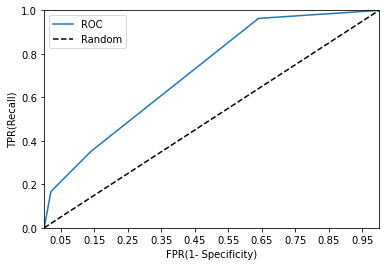

In [132]:
# 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
def roc_curve_plot(y_test, pred_proba):   
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba)

    plt.plot(fprs,tprs,label = 'ROC')
    plt.plot([0,1],[0,1],'k--',label = 'Random')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1- Specificity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

roc_curve_plot(y_test,pred_proba)

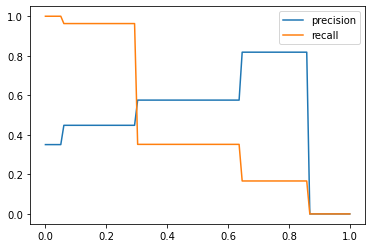

In [133]:
pred_proba1 = pred_proba.reshape(-1,1)

xs = np.linspace(0,1,100)
precision = []
recall = []
for i in xs:
    custom_threshold = i
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba1)
    custom_predict = binarizer.transform(pred_proba1)
    precision.append(precision_score(y_test,custom_predict))
    recall.append(recall_score(y_test,custom_predict))

plt.plot(xs,precision,label='precision')
plt.plot(xs,recall,label = 'recall')
plt.legend()


[도전과제] 

 아래는 백화점 고객의 1년 간 구매 데이터이다.
 
(가) 제공 데이터 목록  
① y_train.csv : 고객의 성별 데이터 (학습용), CSV 형식의 파일  
② X_train.csv, X_test.csv : 고객의 상품구매 속성 (학습용 및 평가용), CSV 형식의 파일  
(나) 데이터 형식 및 내용  
① y_train.csv (3,500명 데이터)  
② X_train.csv (3,500명 데이터), X_test.csv (2,482명 데이터)  

고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용하여 성별예측 모형을 만든 
후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 
다음과 같은 형식의 CSV 파일로 생성하시오.(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 
채점)  

<제출형식>
 custid,gender  
 3500,0.267  
 3501,0.578  
 3502,0.885  
 ․ ․ ․ 
 
 <유의사항>  
성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, Feature Engineering, 분류 
알고리즘 사용, 초매개변수 최적화, 모형 앙상블 등이 수반되어야 한다

 X_train.csv,y_train.csv 로 train,test 으로 나눠서 평가 0.7정도가 나오면 상당히 높은 편

In [134]:
import pandas as pd
X_train = pd.read_csv('./dataset/X_train.csv',encoding='CP949')
y_train = pd.read_csv('./dataset/y_train.csv',encoding='CP949')

In [135]:
display(X_train.head())
display(y_train.head())

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85


,cust_id,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [136]:
# cust_id는 고유 번호이므로 삭제
X = X_train.drop('cust_id',axis=1)
y = y_train.drop('cust_id',axis=1)

In [137]:
# gender 와의 상관성을 찾기 위하여 gender를 합친 데이터 프레임 생성
Xy = pd.concat([X,y],axis =1)
Xy.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0
1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,0
2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16,1
4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,0


In [138]:
# 주구매 상품과의 연관성 파악
Xy[['주구매상품','gender']].groupby('주구매상품').mean()

,gender
주구매상품,
가공식품,0.419414
가구,0.500000
건강식품,0.531915
골프,0.536585
구두,0.518519
기타,0.369748
남성 캐주얼,0.763636
남성 트랜디,0.500000
남성정장,0.818182


In [139]:
# 라벨 인코딩으로 주구매상품 분류
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['주구매상품'] = le.fit_transform(X['주구매상품'])
X.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,5,강남점,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,21,잠실점,2,1.500000,0.000000,1
2,3197000,1639000,NaN,6,관악점,2,2.000000,0.000000,1
3,16077620,4935000,NaN,5,광주점,18,2.444444,0.318182,16
4,29050000,24000000,NaN,15,본 점,2,1.500000,0.000000,85


In [140]:
# 주구매 상품과의 연관성 파악
Xy[['주구매지점','gender']].groupby('주구매지점').mean()

,gender
주구매지점,
강남점,0.255172
관악점,0.413043
광주점,0.403509
노원점,0.311111
대구점,0.714286
대전점,0.357143
동래점,0.346939
미아점,0.434783
본 점,0.402971


In [141]:
# 주구매지점 역시 라벨인코딩으로 변환
X['주구매지점'] = le.fit_transform(X['주구매지점'])
X.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,5,0,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,21,19,2,1.500000,0.000000,1
2,3197000,1639000,NaN,6,1,2,2.000000,0.000000,1
3,16077620,4935000,NaN,5,2,18,2.444444,0.318182,16
4,29050000,24000000,NaN,15,8,2,1.500000,0.000000,85


In [142]:
# 환불 여부와 성별 상관관계 파악
import numpy as np
Xy.환불금액.fillna(0,inplace = True)
Xy['환불금액'] = np.where(Xy.환불금액 == 0 ,0,1)
Xy.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,68282840,11264000,1,기타,강남점,19,3.894737,0.527027,17,0
1,2136000,2136000,1,스포츠,잠실점,2,1.500000,0.000000,1,0
2,3197000,1639000,0,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,16077620,4935000,0,기타,광주점,18,2.444444,0.318182,16,1
4,29050000,24000000,0,보석,본 점,2,1.500000,0.000000,85,0


In [143]:
Xy[['환불금액','gender']].groupby('환불금액').mean()

,gender
환불금액,
0,0.447059
1,0.240664


In [144]:
# X에 Xy의 데이터로 대체
X['환불금액']=Xy['환불금액']
X.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,1,5,0,19,3.894737,0.527027,17
1,2136000,2136000,1,21,19,2,1.500000,0.000000,1
2,3197000,1639000,0,6,1,2,2.000000,0.000000,1
3,16077620,4935000,0,5,2,18,2.444444,0.318182,16
4,29050000,24000000,0,15,8,2,1.500000,0.000000,85


In [145]:
# 최대 구매액 범주화
X.최대구매액.describe()
def get_catmax(X):
    cat = ''                #여기에 저장됨
    if X < 2.875000e+06 : cat = 1
    elif X < 9.837000e+06: cat = 2
    elif X < 2.296250e+07: cat = 3
    else:
        cat = 4
    return cat
Xy['최대구매액'] = Xy['최대구매액'].apply(lambda X : get_catmax(X))
Xy.head()


,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,68282840,3,1,기타,강남점,19,3.894737,0.527027,17,0
1,2136000,1,1,스포츠,잠실점,2,1.500000,0.000000,1,0
2,3197000,1,0,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,16077620,2,0,기타,광주점,18,2.444444,0.318182,16,1
4,29050000,4,0,보석,본 점,2,1.500000,0.000000,85,0


In [146]:
# 나누어진 범주로 성별과의 연관성 파악
Xy[['최대구매액','gender']].groupby('최대구매액').mean()

,gender
최대구매액,
1,0.522883
2,0.372146
3,0.342857
4,0.266286


In [151]:
# X에도 범주 적용
X['최대구매액'] = X['최대구매액'].apply(lambda X : get_catmax(X))
X.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,3,3,1,5,0,19,3.894737,0.527027,17
1,1,1,1,21,19,2,1.500000,0.000000,1
2,1,1,0,6,1,2,2.000000,0.000000,1
3,2,2,0,5,2,18,2.444444,0.318182,16
4,3,4,0,15,8,2,1.500000,0.000000,85


In [147]:
Xy.총구매액.describe()

count    3.500000e+03
mean     9.191925e+07
std      1.635065e+08
min     -5.242152e+07
25%      4.747050e+06
50%      2.822270e+07
75%      1.065079e+08
max      2.323180e+09
Name: 총구매액, dtype: float64

In [148]:
# 총 구매액 범주화
def get_catall(X):
    cat = ''                #여기에 저장됨
    if X < 4.747050e+06 : cat = 1
    elif X < 2.822270e+07 : cat = 2
    elif X < 1.065079e+08 : cat = 3
    else:
        cat = 4
    return cat
Xy['총구매액'] = Xy['총구매액'].apply(lambda X : get_catall(X))
Xy.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender
0,3,3,1,기타,강남점,19,3.894737,0.527027,17,0
1,1,1,1,스포츠,잠실점,2,1.500000,0.000000,1,0
2,1,1,0,남성 캐주얼,관악점,2,2.000000,0.000000,1,1
3,2,2,0,기타,광주점,18,2.444444,0.318182,16,1
4,3,4,0,보석,본 점,2,1.500000,0.000000,85,0


In [149]:
# 나누어진 범주로 성별과의 연관성 파악
Xy[['총구매액','gender']].groupby('총구매액').mean()

,gender
총구매액,
1,0.507429
2,0.427429
3,0.336000
4,0.233143


In [150]:
# X에도 범주 적용
X['총구매액'] = X['총구매액'].apply(lambda X : get_catall(X))
X.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,3,11264000,1,5,0,19,3.894737,0.527027,17
1,1,2136000,1,21,19,2,1.500000,0.000000,1
2,1,1639000,0,6,1,2,2.000000,0.000000,1
3,2,4935000,0,5,2,18,2.444444,0.318182,16
4,3,24000000,0,15,8,2,1.500000,0.000000,85
